In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
loader = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop((256, 395)),
    transforms.ToTensor()])

In [4]:
def load_img(image_name):
    image = loader(Image.open(image_name)).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
style_img = load_img("./night_vangog.jpg")
content_img = load_img("./spb.jpg")
# print(style_img.size())
# print(content_img.size())

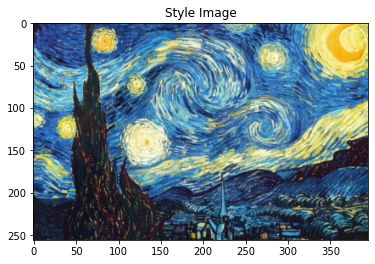

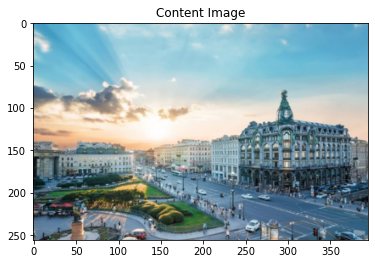

In [6]:
unloader = transforms.ToPILImage()  
plt.ion()

def show_img(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


plt.figure()
show_img(style_img, title='Style Image')

plt.figure()
show_img(content_img, title='Content Image')

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size() 
    features = input.view(a * b, c * d)  

    G = torch.mm(features, features.t()) 
    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [12]:



class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [13]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [14]:


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)


    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

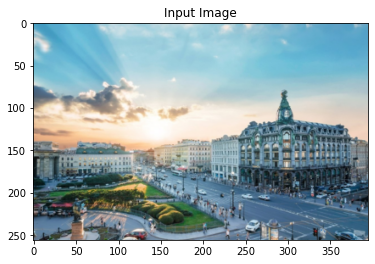

In [15]:
input_img = content_img.clone()
plt.figure()
show_img(input_img, title='Input Image')

In [16]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [17]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Optimizing..
run [50]:
Style Loss : 77.334412 Content Loss: 20.877436

run [100]:
Style Loss : 28.773832 Content Loss: 21.648167

run [150]:
Style Loss : 15.817279 Content Loss: 20.394423

run [200]:
Style Loss : 9.939933 Content Loss: 19.159254

run [250]:
Style Loss : 6.550286 Content Loss: 18.210077

run [300]:
Style Loss : 4.702903 Content Loss: 17.462587



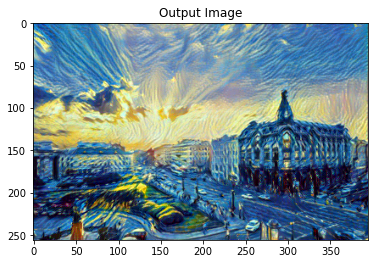

In [18]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
show_img(output, title='Output Image')

plt.ioff()
plt.show()

In [19]:
output

tensor([[[[0.2559, 0.0000, 0.0529,  ..., 0.3302, 0.1930, 0.2257],
          [0.1502, 0.0405, 0.0797,  ..., 0.0940, 0.0041, 0.1389],
          [0.1651, 0.1437, 0.1945,  ..., 0.1584, 0.0609, 0.1551],
          ...,
          [0.1454, 0.1298, 0.1781,  ..., 0.1801, 0.1416, 0.1783],
          [0.2788, 0.1482, 0.1777,  ..., 0.2815, 0.6482, 0.7464],
          [0.4141, 0.2636, 0.2677,  ..., 0.6622, 1.0000, 1.0000]],

         [[0.5780, 0.3239, 0.4103,  ..., 0.5696, 0.5400, 0.4954],
          [0.5094, 0.5052, 0.4264,  ..., 0.5728, 0.5932, 0.5210],
          [0.4105, 0.5086, 0.5328,  ..., 0.5380, 0.5687, 0.5161],
          ...,
          [0.1638, 0.2343, 0.2873,  ..., 0.2693, 0.1949, 0.2704],
          [0.3013, 0.2753, 0.3165,  ..., 0.4022, 0.5231, 0.6921],
          [0.3954, 0.3603, 0.3776,  ..., 0.6676, 1.0000, 0.8989]],

         [[0.7414, 0.6739, 0.6968,  ..., 0.6653, 0.7276, 0.6463],
          [0.7641, 0.8470, 0.7989,  ..., 0.7916, 0.8308, 0.6600],
          [0.7193, 0.7539, 0.7755,  ..., 0

In [20]:
image = output.cpu().clone()  
image = image.squeeze(0)      
image = unloader(image)

In [21]:
# image.save("img6.png","PNG")